# alter-nlu source code breakdown

https://github.com/anuragmishra1/alter-nlu.git


In [95]:
# Dependencies
# ! pip install pandas spacy numpy jsonschema flashtext nltk flask scikit_learn tensorflow-gpu keras fuzzywuzzy python-Levenshtein

# ! python3 - m spacy download en


## Checking data

In [96]:
# Importing libraries
import pandas as pd
import numpy as np


In [97]:
# training data json schema

intent_data_schema = {
    "type": "object",
    "properties": {
        "text": {
            "type": "string",
            "minLength": 1
        },
        "intent": {
            "type": "string",
            "minLength": 1
        },
        "entities": {
            "type": "array",
            "blank": True,
            "items": {
                "type": "object",
                "properties": {
                    "start": {
                        "type": "integer"
                    },
                    "end": {
                        "type": "integer"
                    },
                    "value": {
                        "type": "string",
                        "minLength": 1
                    },
                    "entity": {
                        "type": "string",
                        "minLength": 1
                    }
                },
                "required": [
                    "start",
                    "end",
                    "value",
                    "entity"
                ]
            }
        }
    },
    "required": [
        "text",
        "intent",
        "entities"
    ]
}

entity_data_schema = {
    "type": "object",
    "properties": {
        "name": {
            "type": "string",
            "minLength": 1
        },
        "data": {
            "type": "array",
            "minItems": 1,
            "items": {
                "type": "object",
                "properties": {
                    "value": {
                        "type": "string",
                        "minLength": 1
                    },
                    "synonyms": {
                        "type": "array",
                        "minItems": 1,
                        "items": {
                            "type": "string",
                            "minLength": 1
                        }
                    },
                },
                "required": [
                    "value",
                    "synonyms"
                ]
            }
        }
    },
    "required": [
        "name",
        "data"
    ]
}

botName = {
    "type": "string",
    "minLength": 1
}


In [98]:
# Read docs first : https://json-schema.org/understanding-json-schema/reference/array.html
# https://python-jsonschema.readthedocs.io/en/stable/

from jsonschema import validate

# function to validate training data json from schema
def validate_json(val):
    try:
        # validate intents with schema
        for item in val['intent_data']:
            validate(instance=item, schema=intent_data_schema)

        # validate entities with schema
        for item in val['entity_data']:
            validate(item, entity_data_schema)

        # validate botName with schema
        validate(val['botName'], botName)
        return False
    
    except Exception:
        return True

In [99]:
# just checking if the training data is valid or not
import json

with open('./cloned/alter_nlu/sample_data/training-data.json') as json_file:
    training_data = json.load(json_file)
    if validate_json(training_data):
        print('Invalid training data')
    else:
        print('Valid training data')


Valid training data


In [100]:
# check number of intents
def check_intent_count(val):
    
    intents = set()
    for item in val['intent_data']:
        intents.add(item['intent'])
    print('intents: ', intents)
    intent_count = len(intents)

    # intent_count = len(set(map(lambda datum: datum['intent'], val['intent_data'])))
    
    print('intent count: ', intent_count)
    if intent_count >= 2:
        return False
    else:
        return True


In [101]:
with open('./cloned/alter_nlu/sample_data/training-data.json') as json_file:
    training_data = json.load(json_file)

    if check_intent_count(training_data):
        print('Training data should have at least 2 intents')
    else:
        print('Valid training data')

intents:  {'abusive', 'smalltalk_food', 'smalltalk_language', 'exit', 'ongoing_offers', 'random_queries', 'show_order', 'show_wishlist', 'smalltalk_founder', 'assistance', 'smalltalk_birthday', 'faq', 'search_product', 'smalltalk_caffeine', 'about', 'greet', 'smalltalk_praise'}
intent count:  17
Valid training data


## Prepossessing data
- remove punctuations
- remove pronouns
- stemming
- lemmatization
- clean data
- remove continuous duplicates

In [102]:
import spacy

# download spacy english model
# ! python3 -m spacy download en_core_web_sm
# ! python3 -m spacy download en_core_web_md
# ! python3 -m spacy download en_core_web_lg
# ! python3 -m spacy download en_core_web_trf


# load spacy english model
# nlp = spacy.load("en_core_web_sm")    # small model
# nlp = spacy.load("en_core_web_md")    # medium model
nlp = spacy.load("en_core_web_lg", disable=['ner', 'parser'])   # large model
# nlp = spacy.load("en_core_web_trf")   # transformer model


# add pipeline component
nlp.add_pipe('sentencizer')

In [103]:
import string
print(type(string.punctuation))
print(string.punctuation)

# function to remove punctuation
# def remove_punctuation(text):
#     return text.translate(str.maketrans('', '', string.punctuation))

# doing the same thing with translation table
# translation table that maps each punctuation to whitespace
tr = str.maketrans(string.punctuation, ' '*len(string.punctuation))
print(tr)

# translation table that maps each punctuation to None
# tr_2 = str.maketrans('', '', string.punctuation)
# print(tr_2)


<class 'str'>
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
{33: 32, 34: 32, 35: 32, 36: 32, 37: 32, 38: 32, 39: 32, 40: 32, 41: 32, 42: 32, 43: 32, 44: 32, 45: 32, 46: 32, 47: 32, 58: 32, 59: 32, 60: 32, 61: 32, 62: 32, 63: 32, 64: 32, 91: 32, 92: 32, 93: 32, 94: 32, 95: 32, 96: 32, 123: 32, 124: 32, 125: 32, 126: 32}


In [104]:
# create a stemmer object to remove the affixes from words and return the root word
from nltk.stem.snowball import SnowballStemmer

# Stemmer Language
stemmer = SnowballStemmer("english")

word = 'running'
print(stemmer.stem(word))

run


In [105]:
import re

# function to remove punctuation and extra spaces
def remove_punct(val):
    return (re.sub(' +', ' ', val.translate(tr)).strip())

# sent = 'Hello, how are you?'
# print(remove_punct(sent))


# function to remove pronouns
def remove_pron(val):
    return ' '.join([word for word in val.split() if word != 'pron'])

# sent = 'he is sitting on the chair'
# print(remove_pron(sent))


# function for stemming --> using nltk
def create_stem(val):
    stemmed = ' '.join([stemmer.stem(word) for word in val.split()])
    return (stemmed)

# sent = 'i am running on the road and doing biking'
# print('nltk stemming: ',create_stem(sent))


# function to create lemmatized text --> using spacy
def create_spacy_lemma(val):
    doc = nlp(val)
    lemma_sentence = ' '.join([token.lemma_ for token in doc])
    return (remove_pron(lemma_sentence))

# sent = 'i am running on the road and doing biking'
# print('spacy lemmatizer: ',create_spacy_lemma(sent))


# function to create lemmatized text --> using nltk
# from nltk.stem import WordNetLemmatizer
# import nltk
# nltk.download('wordnet')
# Lemmatizer Language
# lemmatizer = WordNetLemmatizer()

# def create_nltk_lemma(val):
#     lemmatized = ' '.join([lemmatizer.lemmatize(word) for word in val.split()])
#     return (lemmatized)

# sent = 'i am running on the road and doing biking'
# print('nltk lemmatizer: ',create_nltk_lemma(sent))


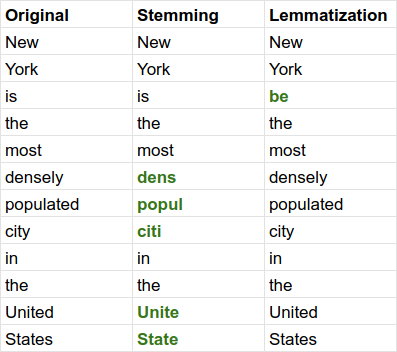

In [106]:
# clean the text
from itertools import zip_longest
def create_spacy_clean(val):
    clean_sentence = remove_pron(remove_punct(create_stem(create_spacy_lemma(val))).lower())
    return (clean_sentence)


# sent = 'Hello, how are you?'
# print('spacy clean: ',create_spacy_clean(sent))

# remove adjacent duplicate tokens
def remove_continuous_duplicates(val):
    check_list = val.split()
    return " ".join([i for i, j in zip_longest(check_list, check_list[1:]) if i != j])

# sent = 'i am running on the road road and doing biking'
# print('remove continuous duplicates: ',remove_continuous_duplicates(sent))

## Prepare data for training

In [107]:
# import tensorflow tokenizer
from keras.preprocessing.text import Tokenizer

# import label encoder for encoding labels
from sklearn.preprocessing import LabelEncoder

# import pad sequences for padding the sequences
from keras.utils import pad_sequences

# prepare data from training
def prepare(val):
    # create the word tokenizer
    word_tokenizer = Tokenizer(oov_token='<UNK>', filters='', lower=False)

    # fit the word tokenizer on the documents
    word_tokenizer.fit_on_texts(val.text)

    # word sequence encode
    word_encoded_docs = word_tokenizer.texts_to_sequences(val.text)

    # pad word sequences
    word_max_length = max([len(s.split()) for s in val.text])

    word_Xtrain = pad_sequences(word_encoded_docs, maxlen=word_max_length, padding='post')

    # encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(val.intent)
    encoded_Y = encoder.transform(val.intent)

    # define word vocabulary size (Adding 1 because of reserved 0 index)
    word_vocab_size = len(word_tokenizer.word_index) + 1

    helper_tokens = (
        word_tokenizer.word_index['<UNK>'], word_tokenizer.word_index['<SOS>'], word_tokenizer.word_index['<EOS>'], 0)
    
    return word_max_length, word_vocab_size, word_Xtrain, encoded_Y, encoder, word_tokenizer, helper_tokens


In [108]:
import pandas as pd

# get structured data
def get_data(val):
    botName = val['botName']

    entity = pd.json_normalize(val['entity_data'], record_path='data', meta='name')

    train = pd.json_normalize(val['intent_data']).drop(['entities'], axis=1).drop_duplicates()

    intent_entity = list(set(pd.json_normalize(
        val['intent_data'], record_path='entities', meta='intent')['intent'].tolist()))

    print('> Training Bot : ' + botName)

    print("\tTotal training examples : {}\n\tIntents : {}".format(
        train.shape[0], len(train['intent'].unique())))
    
    if entity.empty:
        print("\tEntities : Not Added.")
    else:
        print("\tEntities : {}".format(len(entity['name'].unique())))

    return entity, train, intent_entity

## Data Augmentation

In [109]:
import itertools
from flashtext import KeywordProcessor


# Create entity dictionary
def create_dictionary_items(row, dictionary):
    z = list(itertools.product(*[[row['value_name']], row['synonyms']]))
    for item in z:
        new_item = item[0] + (item[1], )
        dictionary.add_keyword(item[1], new_item)


def create_entity_dictionary(val):
    val['value_name'] = list(zip(val.value, val.name))
    entity_dictionary = KeywordProcessor()
    val.apply(create_dictionary_items, args=(entity_dictionary,), axis=1)
    return entity_dictionary

In [110]:
# get stem, lemma of synonyms
def derive_synonyms(val):
    temp = []
    for word in val:
        temp.append(word.lower())
        temp.append(create_spacy_clean(word).lower())
        temp.append(create_stem(word).lower())

    return (list(set(temp)))


def get_derived_synonyms(val):
    val.synonyms = val.synonyms.apply(derive_synonyms)
    return val


# add to dictionary for replacement
def create_synonym_dictonary(val):
    kp = KeywordProcessor()
    val = get_derived_synonyms(val)
    val.synonyms.apply(kp.add_keywords_from_list)
    return kp


# replace synonyms
def multipleReplace(text, wordDict):
    kp_replace = KeywordProcessor()
    for key in wordDict:
        kp_replace.add_keyword(key, wordDict[key])
        mod_text = kp_replace.replace_keywords(text)
    return mod_text


# create derived training data
def create_derived(kp, val1, val2):
    keywords = kp.extract_keywords(val1[1])
    if len(keywords) != 0:
        derived_queries, synonym_list = [], []
        for keyword in keywords:
            for synonym in val2.synonyms:
                if keyword in synonym:
                    synonym_list.append(synonym)
        all_combo = list(itertools.product(*synonym_list))

        for combo in all_combo:
            derived_query = multipleReplace(
                val1[1].lower(), dict(zip(keywords, list(combo))))
            derived_queries.append(derived_query)

        return pd.DataFrame({'text': list(set(derived_queries)), 'intent': val1[0]})
    else:
        return pd.DataFrame({'text': [val1[1]], 'intent': val1[0]})


# add EOS and SOS token
def add_sos_eos(val):
    return '<SOS> ' + val + ' <EOS>'


# Data augmentation
def process_data(val1, val2):
    derived_train = pd.DataFrame()
    kp = create_synonym_dictonary(val2)

    print("> Data Augmentation")
    for val in val1.values.tolist():
        derived_train = pd.concat(
            [derived_train, create_derived(kp, val, val2)], sort=True)

    # all training data
    val3 = pd.concat([val1, derived_train])

    # drop duplicates
    val3.drop_duplicates(inplace=True)

    # apply preprocessing function
    print("> Preprocessing")
    val3.text = val3.text.apply(create_spacy_clean)
    val3.text = val3.text.apply(remove_continuous_duplicates)

    # drop duplicate sentences(if any)
    val3.drop_duplicates(inplace=True)

    # shuffle tranining data
    val3 = val3.sample(frac=1).reset_index(drop=True)

    # create entity dictionary
    print("> Entity Dictionary")
    entity_extractor = create_entity_dictionary(val2)

    # add EOS and SOS
    val3['text'] = val3['text'].apply(add_sos_eos)

    return val3, entity_extractor


# no entity process data
def no_entity_process_data(val1):
    # apply preprocessing function
    print("> Preprocessing")
    val1.text = val1.text.apply(create_spacy_clean)

    # drop duplicate sentences(if any)
    val1.drop_duplicates(inplace=True)

    # shuffle training data
    val1 = val1.sample(frac=1).reset_index(drop=True)

    # create empty dictionary
    entity_extractor = KeywordProcessor()

    # add EOS and SOS
    val1['text'] = val1['text'].apply(add_sos_eos)

    return val1, entity_extractor

## Model Training

In [111]:
from keras.layers import Dense, Dropout, Embedding, Input, GlobalMaxPool1D, BatchNormalization, concatenate, Conv1D
from keras.models import Model


# classification model
def model_def(x, y, z):
    input_1 = Input(shape=(x,))
    embedding_1 = Embedding(y, 128, input_length=x)(input_1)

    conv_1 = Conv1D(32, 1, use_bias=True, padding='valid',
                    activation='relu')(embedding_1)
    normalized_1 = BatchNormalization()(conv_1)
    drop_out_1 = Dropout(0.5)(normalized_1)
    pooling_1 = GlobalMaxPool1D()(drop_out_1)

    conv_2 = Conv1D(32, 2, use_bias=True, padding='valid',
                    activation='relu')(embedding_1)
    normalized_2 = BatchNormalization()(conv_2)
    drop_out_2 = Dropout(0.5)(normalized_2)
    pooling_2 = GlobalMaxPool1D()(drop_out_2)

    conv_3 = Conv1D(32, 3, use_bias=True, padding='valid',
                    activation='relu')(embedding_1)
    normalized_3 = BatchNormalization()(conv_3)
    drop_out_3 = Dropout(0.5)(normalized_3)
    pooling_3 = GlobalMaxPool1D()(drop_out_3)

    merged_1 = concatenate([pooling_1, pooling_2, pooling_3])

    dense_1 = Dense(2*len(z), activation='relu', use_bias=True)(merged_1)
    dense_2 = Dense(2*len(z), activation='relu', use_bias=True)(dense_1)
    dense_3 = Dense(2*len(z), activation='relu', use_bias=True)(dense_2)

    dense_4 = Dense(len(z), activation='softmax', use_bias=True)(dense_3)
    final_model = Model(inputs=[input_1], outputs=[dense_4])
    final_model.compile(optimizer='adam', loss='categorical_crossentropy')

    return final_model


In [112]:
# Model Saveing
import os
import shutil
import pickle


# pickle format file save
def save_pkl(input_file, output_file):
    with open(output_file, 'wb') as handle:
        pickle.dump(input_file, handle, protocol=pickle.HIGHEST_PROTOCOL)


# pickle format file load
def load_pkl(file_name):
    with open(file_name, 'rb') as handle:
        var = pickle.load(handle)
        return var


models_dir = './bot_model'
def reset_botmodel():
    if not os.path.exists(models_dir):
        os.mkdir(models_dir)
    else:
        print("> Reset Model")
        shutil.rmtree(models_dir)
        os.mkdir(models_dir)
    return

# save bot metadata
def save_metadata(input_file):
    reset_botmodel()
    print("> Saving Metadata")
    save_pkl(input_file, models_dir + '/metadata')
    return


In [113]:
# Validation
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import matthews_corrcoef


# check validation score and save intent model
class Metrics(Callback):
    def __init__(self):
        self.mccs = []
        self.fit_score = {}

    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.argmax(np.asarray(
            self.model.predict([self.validation_data[0]])), axis=-1)
        val_targ = np.argmax(self.validation_data[1], axis=-1)
        mcc = matthews_corrcoef(val_targ.tolist(), val_predict.tolist())
        self.mccs.append(mcc)
        if len(self.mccs) > 1:
            if mcc >= max(self.mccs[:-1]):
                diff = 1 / (abs((logs.get('val_loss')/logs.get('loss'))-1)
                            * logs.get('val_loss')*logs.get('loss'))
                temp = [] if mcc not in self.fit_score else self.fit_score[mcc]
                temp.append(diff)
                self.fit_score[mcc] = temp
                if len(self.fit_score[mcc]) > 1:
                    if diff >= max(self.fit_score[mcc][:-1]):
                        self.model.save(models_dir + '/model.h5')
                else:
                    self.model.save(models_dir + '/model.h5')
        else:
            self.model.save(models_dir + '/model.h5')
        return

In [114]:
from sklearn.model_selection import StratifiedShuffleSplit
from keras.utils import to_categorical


# Training
def start_train(data):
    entity, train, intent_entity = get_data(data)

    if entity.empty:
        train, entity_extractor = no_entity_process_data(train)
    else:
        train, entity_extractor = process_data(train, entity)

    word_max_length, word_vocab_size, word_Xtrain, ytrain, encoder, word_tokenizer, helper_tokens = prepare(train)

    final_model = model_def(word_max_length, word_vocab_size, encoder.classes_)

    save_metadata((intent_entity, entity_extractor, word_tokenizer,encoder, word_max_length, helper_tokens))

    mcc = Metrics()

    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3)

    print("> Training Intent Model")
    for train_index, test_index in sss.split(word_Xtrain, ytrain):

        X_train, X_test = word_Xtrain[train_index], word_Xtrain[test_index]

        y_train, y_test = to_categorical(ytrain[train_index]), to_categorical(ytrain[test_index])

        final_model.fit(X_train, y_train, epochs=20, verbose=0, shuffle=True,validation_data=(X_test, y_test), callbacks=[mcc])
    
    del final_model

    return


In [115]:
# Load Model if already trained
from fuzzywuzzy import process, fuzz
import os
from keras.models import load_model


# load bot from filesystem
def loader():
    if not os.path.exists(models_dir):
        print('> NO EXISTING BOT FOUND.')
    else:
        print('> LOADING BOT')
        if os.path.exists(models_dir + '/model.h5') and os.path.exists(models_dir + '/metadata'):
            model = load_model(models_dir + '/model.h5')
            metadata = load_pkl(models_dir + '/metadata')
            print('> LOADING DONE')
            return metadata, model
        else:
            print('!! Incomplete Training. Skipping...')

    return None, None

# load bot models
def load_all():
    global metadata, model
    metadata, model = loader()

# train and load continuously
def train_n_load(data):
    if validate_json(data):
        return {"error": "Invalid training data format!", "statusCode": 400}
    if check_intent_count(data):
        return {"error": "At least 2 intents required!", "statusCode": 400}
    global metadata, model
    start_train(data)
    metadata, model = loader()
    return {"message": "Training Complete & Model Deployed Successfully!", "statusCode": 200}


# Get entity from input query
def extract_entity(text, dictionary):
    entity_output = []
    text = create_spacy_clean(text)
    for user_entity in dictionary.extract_keywords(text):
        output = {"value": str(user_entity[0]),
                  "category": str(user_entity[1])}
        if output not in entity_output:
            entity_output.append(
                {"value": str(user_entity[0]), "category": str(user_entity[1])})

    synonyms = list(dictionary.get_all_keywords().keys())
    for synonym in process.extractBests(text, synonyms, score_cutoff=90, scorer=fuzz.token_set_ratio):
        entities = dictionary.extract_keywords(synonym[0])
        output = {"value": str(entities[0][0]),
                  "category": str(entities[0][1])}
        if output not in entity_output:
            entity_output.append(
                {"value": str(entities[0][0]), "category": str(entities[0][1])})

    return entity_output



# get intent of input query
def get_intent(text, metadata, model):
    text_query = ['<SOS> ' + create_spacy_clean(text) + ' <EOS>']
    word_encoded_docs = metadata[2].texts_to_sequences(text_query)
    word_Xtest = pad_sequences(
        word_encoded_docs, maxlen=metadata[4], padding='post')

    if len(set(word_Xtest[0])-set(metadata[5])) != 0:
        prediction = model.predict([word_Xtest])[0]
        if max(prediction) > 0.5:
            output = [metadata[3].classes_[
                list(prediction).index(max(prediction))], max(prediction)]
            return output[0], output[1]
        else:
            return 'fallback', 0
    else:
        return 'fallback', 0



# convert input query to structured data
def extract_info(data):
    try:
        intent, confidence = get_intent(data['text'], metadata, model)
    except TypeError:
        return {"error": "No Bot Trained!", "statusCode": 400}
    if intent in metadata[0]:
        entities = extract_entity(data['text'], metadata[1])
    else:
        entities = []
    return {
        "intent": intent, 
        "confidence": round(float(confidence), 4), 
        "entities": entities
            }

In [117]:
# Start Training and Loading Bot
load_all()
with open('./cloned/alter_nlu/sample_data/training-data.json') as f:
    data = json.load(f)
    # train_n_load(data)

> LOADING BOT
!! Incomplete Training. Skipping...
